In [5]:
!apt-get install -qq libgdal-dev libspatialindex-dev
!pip install -q rasterio geopandas shapely pyproj scipy

In [3]:
from google.colab import files

uploaded = files.upload()

Saving Site01_ROIs.tgz to Site01_ROIs.tgz
Saving Site01_final_adj_5mpp_surf.tif to Site01_final_adj_5mpp_surf.tif


In [6]:
import tarfile
import os

os.makedirs("Site01_ROIs", exist_ok=True)


with tarfile.open("Site01_ROIs.tgz", "r:gz") as tar:
    tar.extractall(path="Site01_ROIs")

In [7]:
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.features import geometry_mask

with rasterio.open("Site01_final_adj_5mpp_surf.tif") as src:
    dem = src.read(1)
    transform = src.transform
    crs = src.crs

roi_gdf = gpd.read_file("Site01_ROIs/Site01_ROIs.shp")
roi_gdf = roi_gdf.to_crs(crs)

roi_mask = geometry_mask(
    roi_gdf.geometry,
    transform=transform,
    invert=True,
    out_shape=dem.shape
)

dem_masked = np.where(roi_mask, dem, np.nan)

In [8]:
from scipy.ndimage import gaussian_filter, sobel

dem_smoothed = gaussian_filter(dem_masked, sigma=1)

dzdx = sobel(dem_smoothed, axis=1) / 5.0
dzdy = sobel(dem_smoothed, axis=0) / 5.0

slope_deg = np.degrees(np.arctan(np.sqrt(dzdx**2 + dzdy**2)))

pois = []
for geom in roi_gdf.geometry:
    centroid = geom.centroid
    row, col = ~transform * (centroid.x, centroid.y)
    pois.append((int(round(row)), int(round(col))))

dist_to_poi = np.full(dem.shape, np.inf)
for i in range(dem.shape[0]):
    for j in range(dem.shape[1]):
        if np.isnan(dem_masked[i, j]):
            continue
        dist_to_poi[i, j] = min([np.hypot(i - pi, j - pj) for (pi, pj) in pois])

In [9]:
import matplotlib.pyplot as plt

valid_mask = ~np.isnan(slope_deg)

norm_slope = np.zeros_like(slope_deg)
norm_dist = np.zeros_like(dist_to_poi)

norm_slope[valid_mask] = (
    (slope_deg[valid_mask] - np.min(slope_deg[valid_mask]))
    / np.ptp(slope_deg[valid_mask])
)
norm_dist[valid_mask] = (
    (dist_to_poi[valid_mask] - np.min(dist_to_poi[valid_mask]))
    / np.ptp(dist_to_poi[valid_mask])
)

suitability = np.zeros_like(dem)
suitability[valid_mask] = 1 / (1 + 2 * norm_slope[valid_mask] + 1 * norm_dist[valid_mask])

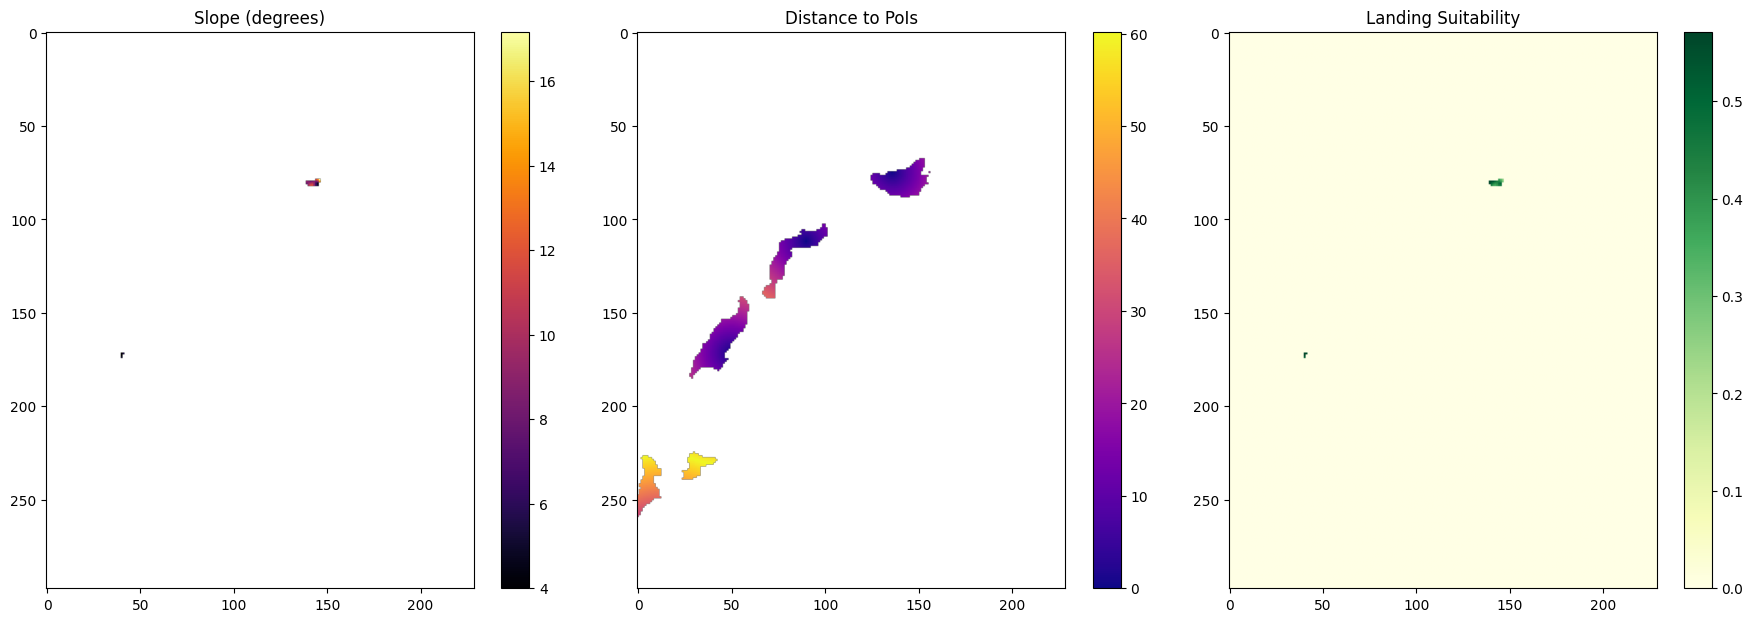

In [10]:
minx, miny, maxx, maxy = roi_gdf.total_bounds
row_min, col_min = ~transform * (minx, maxy)
row_max, col_max = ~transform * (maxx, miny)

row_min, row_max = int(max(row_min, 0)), int(min(row_max, dem.shape[0]))
col_min, col_max = int(max(col_min, 0)), int(min(col_max, dem.shape[1]))

dem_crop = dem[row_min:row_max, col_min:col_max]
slope_crop = slope_deg[row_min:row_max, col_min:col_max]
dist_crop = dist_to_poi[row_min:row_max, col_min:col_max]
suit_crop = suitability[row_min:row_max, col_min:col_max]


plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(slope_crop, cmap='inferno')
plt.title("Slope (degrees)")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(dist_crop, cmap='plasma')
plt.title("Distance to PoIs")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(suit_crop, cmap='YlGn')
plt.title("Landing Suitability")
plt.colorbar()

plt.tight_layout()
plt.show()

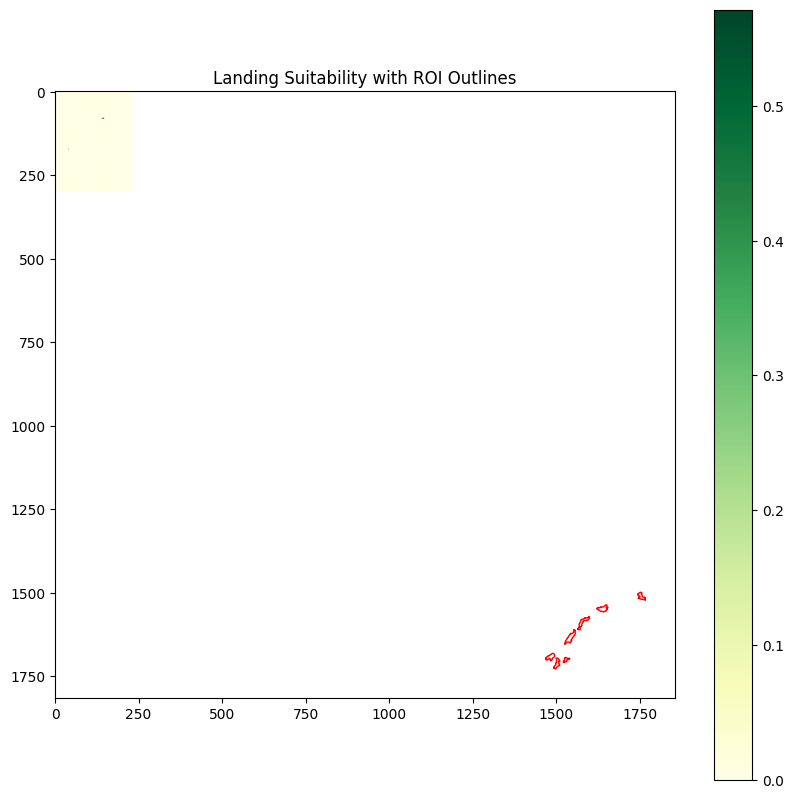

In [11]:
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(suit_crop, cmap='YlGn')
plt.colorbar(im)

for geom in roi_gdf.geometry:
    if geom.geom_type == 'Polygon':
        x, y = geom.exterior.xy
        coords = np.vstack([x, y])
        px, py = (~transform) * coords
        ax.plot(px, py, color='red', linewidth=1)

plt.title("Landing Suitability with ROI Outlines")
plt.show()


In [12]:
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.transform import Affine
from shapely.geometry import mapping
from scipy.ndimage import gaussian_filter, sobel
import matplotlib.pyplot as plt

with rasterio.open("Site01_final_adj_5mpp_surf.tif") as src:
    dem = src.read(1)
    transform = src.transform
    crs = src.crs

roi_gdf = gpd.read_file("Site01_ROIs/Site01_ROIs.shp")
roi_gdf = roi_gdf.to_crs(crs)

dem_smoothed = gaussian_filter(dem, sigma=1)
dzdx = sobel(dem_smoothed, axis=1) / 5.0
dzdy = sobel(dem_smoothed, axis=0) / 5.0
slope_rad = np.arctan(np.sqrt(dzdx**2 + dzdy**2))
slope_deg = np.degrees(slope_rad)

pois = []
for geom in roi_gdf.geometry:
    centroid = geom.centroid
    row, col = ~transform * (centroid.x, centroid.y)
    pois.append((int(round(row)), int(round(col))))

dist_to_poi = np.full(dem.shape, np.inf)
rows, cols = np.indices(dem.shape)
for poi_r, poi_c in pois:
    dist = np.hypot(rows - poi_r, cols - poi_c)
    dist_to_poi = np.minimum(dist_to_poi, dist)

valid_mask = ~np.isnan(slope_deg)

norm_slope = np.zeros_like(slope_deg)
norm_dist = np.zeros_like(dist_to_poi)

norm_slope[valid_mask] = (slope_deg[valid_mask] - np.min(slope_deg[valid_mask])) / np.ptp(slope_deg[valid_mask])
norm_dist[valid_mask] = (dist_to_poi[valid_mask] - np.min(dist_to_poi[valid_mask])) / np.ptp(dist_to_poi[valid_mask])

suitability = np.zeros_like(dem)
suitability[valid_mask] = 1 / (1 + 2 * norm_slope[valid_mask] + 1 * norm_dist[valid_mask])

In [13]:
flat_suitability = suitability.copy()
flat_suitability[~valid_mask] = -np.inf

sorted_coords = np.dstack(np.unravel_index(np.argsort(flat_suitability.ravel())[::-1], flat_suitability.shape))[0]
top5_pixels = sorted_coords[:5]

top5_coords = [transform * (int(c[1]), int(c[0])) for c in top5_pixels]
print("Top 5 landing spots (x, y in meters):")
for i, coord in enumerate(top5_coords, 1):
    print(f"{i}. X: {coord[0]:.2f} m, Y: {coord[1]:.2f} m")

Top 5 landing spots (x, y in meters):
1. X: -10940.00 m, Y: -11700.00 m
2. X: -10545.00 m, Y: -11615.00 m
3. X: -10900.00 m, Y: -11910.00 m
4. X: -10540.00 m, Y: -11620.00 m
5. X: -10290.00 m, Y: -11620.00 m


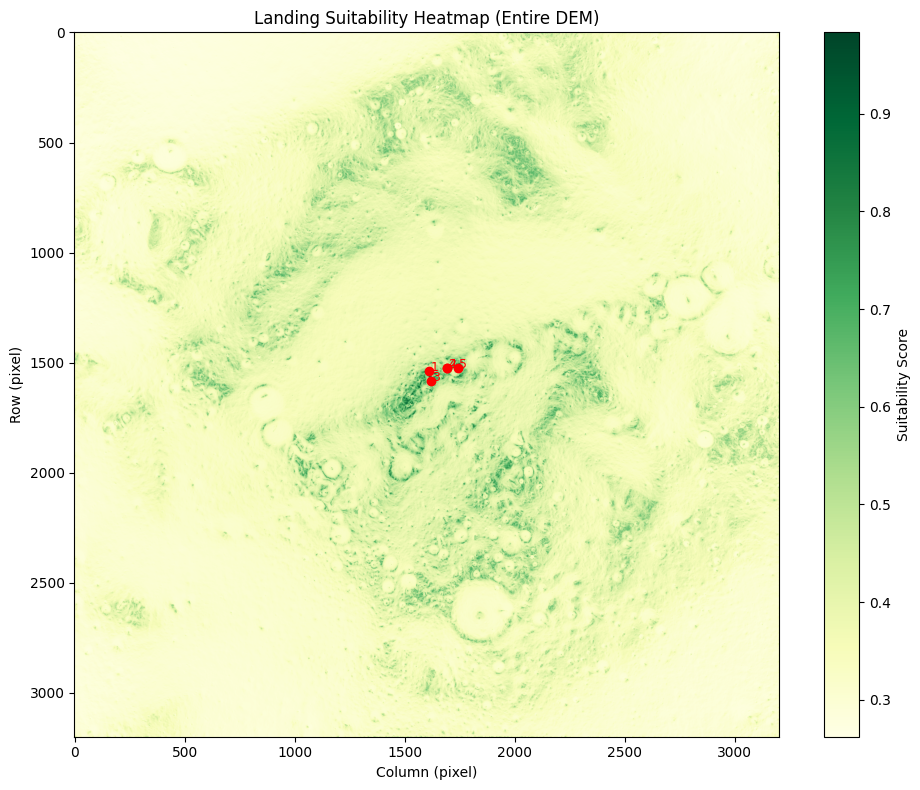

In [14]:
plt.figure(figsize=(10, 8))
plt.imshow(suitability, cmap="YlGn", origin="upper")
plt.colorbar(label="Suitability Score")
plt.title("Landing Suitability Heatmap (Entire DEM)")

for i, (row, col) in enumerate(top5_pixels, 1):
    plt.plot(col, row, marker="o", color="red")
    plt.text(col + 5, row, f"{i}", color="red", fontsize=9)

plt.xlabel("Column (pixel)")
plt.ylabel("Row (pixel)")
plt.tight_layout()
plt.show()

In [15]:
!pip install descartes

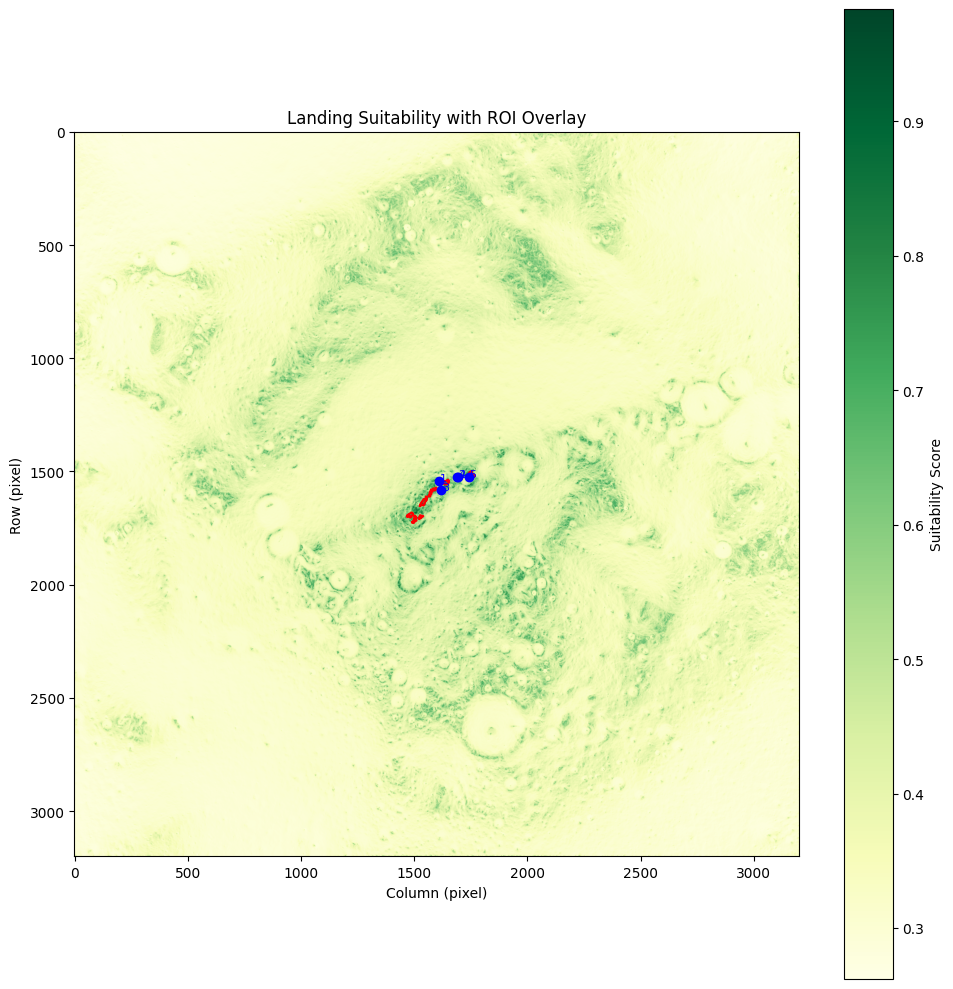

In [16]:
from shapely.geometry import mapping
import matplotlib.patches as mpatches
from descartes import PolygonPatch

fig, ax = plt.subplots(figsize=(10, 10))

img = ax.imshow(suitability, cmap="YlGn", origin="upper")
plt.colorbar(img, ax=ax, label="Suitability Score")
ax.set_title("Landing Suitability with ROI Overlay")

for geom in roi_gdf.geometry:
    if geom.geom_type == 'Polygon':
        x, y = geom.exterior.xy
        coords = np.vstack([x, y])
        px, py = (~transform) * coords
        ax.plot(px, py, color="red", linewidth=1.5, label="ROI Boundary")

for i, (row, col) in enumerate(top5_pixels, 1):
    ax.plot(col, row, marker="o", color="blue")
    ax.text(col + 3, row, f"{i}", color="blue", fontsize=8)

ax.set_xlabel("Column (pixel)")
ax.set_ylabel("Row (pixel)")
plt.tight_layout()
plt.show()

In [25]:
hazard_slope_threshold = 40
hazard_map = slope_deg > hazard_slope_threshold

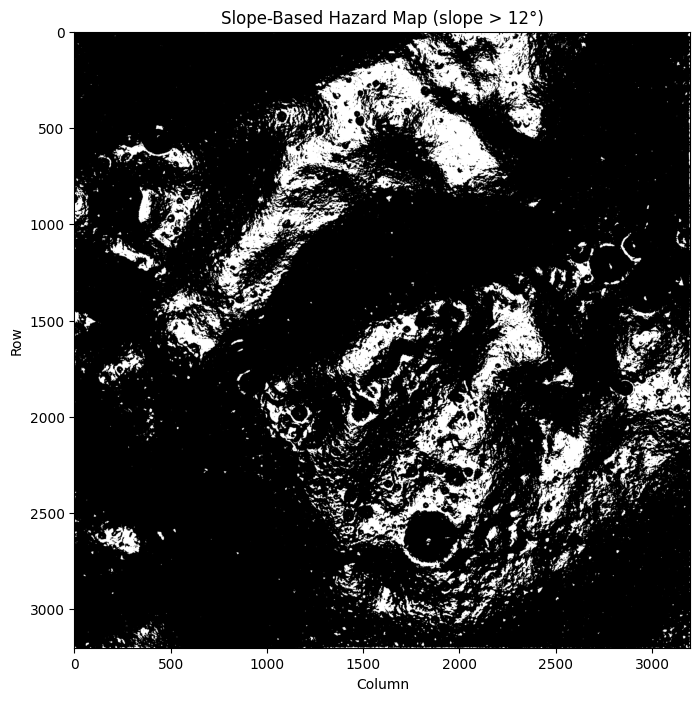

In [26]:
plt.figure(figsize=(8, 8))
plt.imshow(hazard_map, cmap='gray_r', origin='upper')
plt.title("Slope-Based Hazard Map (slope > 12°)")
plt.xlabel("Column")
plt.ylabel("Row")
plt.show()

In [27]:
poi_pixels = []
for geom in roi_gdf.geometry:
    centroid = geom.centroid
    row, col = ~transform * (centroid.x, centroid.y)
    poi_pixels.append((int(round(row)), int(round(col))))

In [28]:
from scipy.spatial.distance import cdist
import numpy as np

# landing_site = top5_coords[0]
landing_site = tuple(top5_pixels[0])

poi_array = np.array(poi_pixels)
landing_array = np.array([landing_site])
dists = cdist(landing_array, poi_array)[0]

closest_indices = np.argsort(dists)[:5]
closest_goals = [tuple(poi_pixels[i]) for i in closest_indices]

In [29]:
import networkx as nx

def create_grid_graph(mask):
    G = nx.grid_2d_graph(*mask.shape)
    for (r, c), is_hazard in np.ndenumerate(mask):
        if is_hazard or np.isnan(suitability[r, c]):
            G.remove_node((r, c))
    return G

def astar_path(graph, start, goal):
    try:
        return nx.astar_path(graph, start, goal, heuristic=lambda a, b: np.linalg.norm(np.array(a) - np.array(b)))
    except nx.NetworkXNoPath:
        return None

In [30]:
import networkx as nx
import numpy as np
from scipy.spatial.distance import cdist


def create_grid_graph(mask):
    G = nx.grid_2d_graph(*mask.shape)
    for (r, c), is_hazard in np.ndenumerate(mask):
        if is_hazard or np.isnan(suitability[r, c]):
            G.remove_node((r, c))
    return G

def astar_path(graph, start, goal):
    try:
        return nx.astar_path(graph, start, goal, heuristic=lambda a, b: np.linalg.norm(np.array(a) - np.array(b)))
    except nx.NetworkXNoPath:
        return None

def is_valid_node(r, c):
    return (
        0 <= r < hazard_map.shape[0] and
        0 <= c < hazard_map.shape[1] and
        not hazard_map[r, c] and
        ((r, c) in G)
    )

landing_site = tuple(top5_pixels[0])

poi_pixels = []
for geom in roi_gdf.geometry:
    centroid = geom.centroid
    row, col = ~transform * (centroid.x, centroid.y)
    poi_pixels.append((int(round(row)), int(round(col))))

G = create_grid_graph(hazard_map)

dists = cdist([landing_site], poi_pixels)[0]
sorted_indices = np.argsort(dists)

max_paths = 5
paths = []

for idx in sorted_indices:
    goal = poi_pixels[idx]

    if not is_valid_node(*goal):
        continue

    path = astar_path(G, landing_site, goal)

    if path and all(not hazard_map[r, c] for r, c in path):
        paths.append((goal, path))
        print(f"✓ Valid path to ROI {goal} ({len(path)} steps)")
    else:
        print(f"✗ Skipping path to ROI {goal} due to obstacle")

    if len(paths) == max_paths:
        break

✓ Valid path to ROI (1543, 1634) (26 steps)
✓ Valid path to ROI (1580, 1588) (65 steps)
✓ Valid path to ROI (1529, 1700) (112 steps)
✓ Valid path to ROI (1483, 1692) (186 steps)
✓ Valid path to ROI (1502, 1712) (145 steps)


In [23]:
for i, (goal, path) in enumerate(paths, 1):
    print(f"\nPath {i} → ROI at pixel {goal} ({len(path)} steps):")
    print(path)


Path 1 → ROI at pixel (1580, 1588) (65 steps):
[(np.int64(1540), np.int64(1612)), (1541, 1612), (1542, 1612), (1543, 1612), (1544, 1612), (1545, 1612), (1545, 1611), (1545, 1610), (1546, 1610), (1546, 1609), (1546, 1608), (1547, 1608), (1548, 1608), (1549, 1608), (1549, 1607), (1549, 1606), (1549, 1605), (1549, 1604), (1549, 1603), (1549, 1602), (1549, 1601), (1549, 1600), (1550, 1600), (1550, 1599), (1551, 1599), (1552, 1599), (1552, 1598), (1553, 1598), (1553, 1597), (1553, 1596), (1553, 1595), (1553, 1594), (1553, 1593), (1554, 1593), (1555, 1593), (1556, 1593), (1556, 1592), (1557, 1592), (1558, 1592), (1559, 1592), (1560, 1592), (1561, 1592), (1562, 1592), (1563, 1592), (1564, 1592), (1565, 1592), (1566, 1592), (1567, 1592), (1568, 1592), (1569, 1592), (1570, 1592), (1571, 1592), (1572, 1592), (1573, 1592), (1574, 1592), (1575, 1592), (1576, 1592), (1577, 1592), (1577, 1591), (1578, 1591), (1578, 1590), (1579, 1590), (1579, 1589), (1580, 1589), (1580, 1588)]


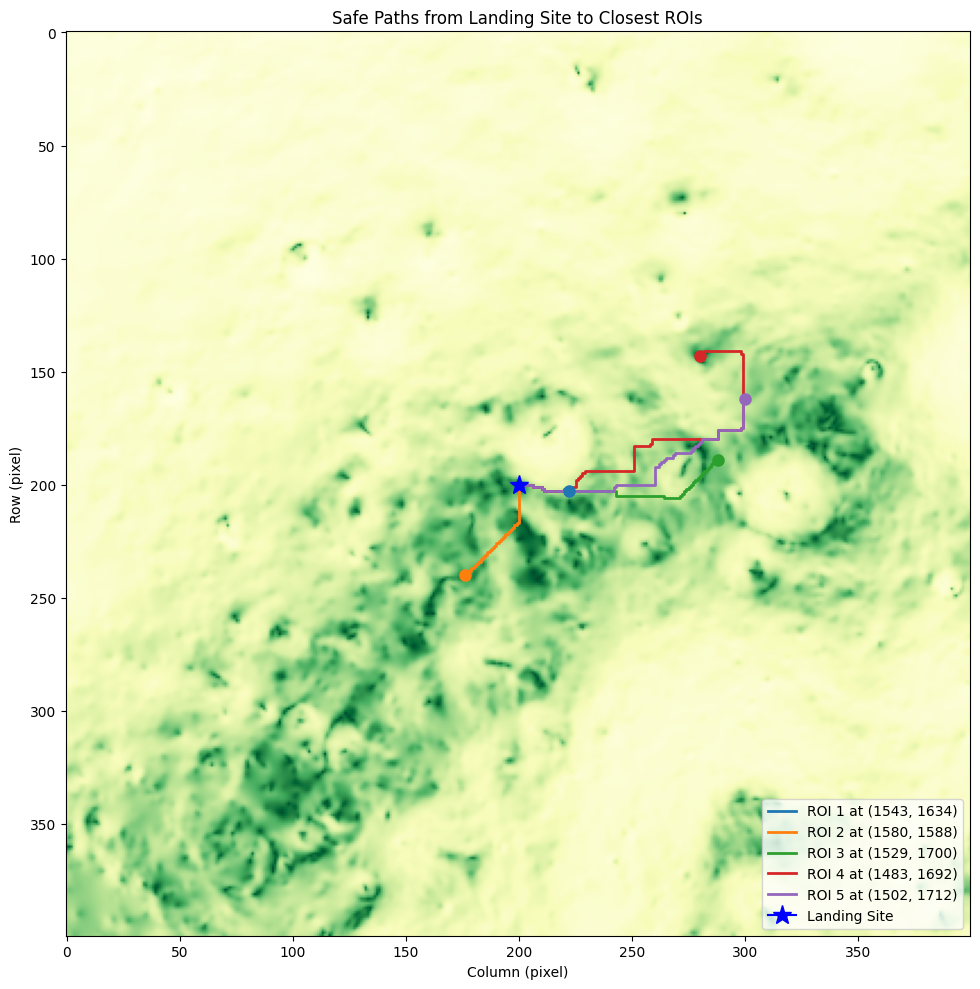

In [31]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

colors = list(mcolors.TABLEAU_COLORS.values())[:len(paths)]

zoom_size = 200
r0, c0 = landing_site
rmin, rmax = max(r0 - zoom_size, 0), min(r0 + zoom_size, suitability.shape[0])
cmin, cmax = max(c0 - zoom_size, 0), min(c0 + zoom_size, suitability.shape[1])

plt.figure(figsize=(10, 10))
plt.imshow(suitability[rmin:rmax, cmin:cmax], cmap="YlGn", origin="upper")
plt.title("Safe Paths from Landing Site to Closest ROIs")

for i, (goal, path) in enumerate(paths):
    pr = [r - rmin for r, _ in path]
    pc = [c - cmin for _, c in path]
    plt.plot(pc, pr, label=f"ROI {i+1} at {goal}", color=colors[i], linewidth=2)

plt.plot(c0 - cmin, r0 - rmin, marker='*', color='blue', markersize=14, label='Landing Site')

for i, (goal, _) in enumerate(paths):
    gr, gc = goal
    plt.plot(gc - cmin, gr - rmin, marker='o', color=colors[i], markersize=8)

plt.legend(loc='lower right')
plt.xlabel("Column (pixel)")
plt.ylabel("Row (pixel)")
plt.grid(False)
plt.tight_layout()
plt.show()